In [1]:
import numpy as np
import tensorly as tl
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly import tucker_to_tensor

from sklearn.utils.extmath import randomized_svd
from itertools import combinations, product
import multiprocessing as mp
import time

import apgpy
from scipy.sparse.linalg import svds
import mkl
mkl.set_num_threads(1)

from util import std_logistic_function, get_square_set, square_unfolding, \
normalized_error, tenips_general, tenips_general_paper1, generate_orthogonal_mats

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

## Part I: function definitions

1-bit matrix completion

In [23]:
def one_bit_MC_fully_observed(M, link, tau, gamma, max_rank=None,
                              apg_max_iter=500, apg_eps=1e-12,
                              apg_use_restart=True):
    """
    Do one-bit matrix completion on the mask matrix M. 
    """
    m = M.shape[0]
    n = M.shape[1]
    tau_sqrt_mn = tau * np.sqrt(m*n)

    def prox(_A, t):
        _A = _A.reshape(m, n)
        if max_rank is None:
            U, S, VT = np.linalg.svd(_A, full_matrices=False)
        else:
            U, S, VT = randomized_svd(_A, max_rank)
        nuclear_norm = np.sum(S)
        if nuclear_norm > tau_sqrt_mn:
            S *= tau_sqrt_mn / nuclear_norm
            _A = np.dot(U * S, VT)

        mask = np.abs(_A) > gamma
        if mask.sum() > 0:
            _A[mask] = np.sign(_A[mask]) * gamma

        return _A.flatten()

    M_one_mask = (M == 1)
    M_zero_mask = (M == 0)
    def grad(_A):
        _A = _A.reshape(m, n)
        return (std_logistic_function(_A) - M).flatten()

    A_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True)
    P_hat = link(A_hat.reshape(m, n))
    return P_hat

## Part 2: experiments

Parameter setup for experiments. For Figure 5 in supplementary material, Section 2, change I to 5 and orders to np.linspace(4, 10, 7).astype(int).

In [55]:
N = 4
r = [2 for _ in range(N)]
I = 8
orders = np.linspace(4, 8, 5).astype(int)

generate data tensor $\mathscr{B}$

In [56]:
# # Low rank + noise
# np.random.seed(1)
# noise_para = 0.1 # noise parameter

# real_core = 100 * tl.tensor(np.random.randn(*r))
# factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
# real_B = tucker_to_tensor((real_core, factor_matrices)) # noiseless
# fro_norm = np.linalg.norm(real_B)
# noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
# noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))

# B = real_B + noise_coeff*noise_ten # noisy

generate parameter tensor $\mathscr{A}$

In [57]:
A_noise_para = 0.1 # noise parameter
np.random.seed(2)
A_real_core = 2 * np.random.uniform(-1, 1, r)
A_factor_matrices = [generate_orthogonal_mats((I, r[0])) for i in range(N)]
real_A = tucker_to_tensor((A_real_core, A_factor_matrices)) # noiseless
A_fro_norm = np.linalg.norm(real_A)
A_noise_coeff = A_noise_para * A_fro_norm / I ** (len(r)*1./2)
A_noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))

A = real_A + A_noise_coeff * A_noise_ten #noisy

get propensity tensor $\mathscr{P}$

In [58]:
P = std_logistic_function(A)

propensity distribution

(array([   3.,   11.,   64.,  353., 1765., 1523.,  297.,   61.,   14.,
           5.]),
 array([0.42077697, 0.43678848, 0.4528    , 0.46881151, 0.48482302,
        0.50083453, 0.51684605, 0.53285756, 0.54886907, 0.56488058,
        0.5808921 ]),
 <a list of 10 Patch objects>)

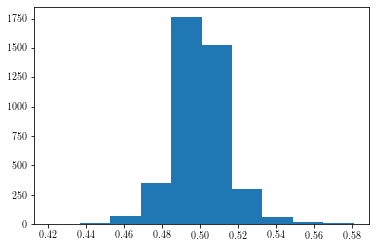

In [59]:
plt.hist(P.flatten())

Case 1: rectangular unfolding

In [60]:
A_rect = tl.unfold(A, mode=0)
_, A_Sigma, _ = randomized_svd(A_rect, n_components=10, n_iter=20, random_state=None)
alpha_of_A_rect = np.max(np.abs(A_rect))
theta_of_A_rect = np.sum(A_Sigma) / (np.sqrt(np.prod(A_rect.shape)))

In [61]:
A_Sigma

array([3.29865596, 1.36562825, 0.1363851 , 0.13379199, 0.13027435,
       0.1250826 , 0.12043247, 0.11833373])

In [62]:
theta_of_A_rect

0.08482163194454842

In [63]:
alpha_of_A_rect

0.3264366005679022

Case 2: square unfolding

In [64]:
A_sq = square_unfolding(A)
_, A_Sigma, _ = randomized_svd(A_sq, n_components=10, n_iter=20, random_state=None)
alpha_of_A_sq = np.max(np.abs(A_sq))
theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape)))

In [65]:
theta_of_A_sq

0.0980229845656162

In [66]:
alpha_of_A_sq

0.3264366005679022

Model A: MCAR

In [67]:
def uniform_sampling(ratio, tensor):
    """
    Uniformly sample the given tensor with given ratio. Output the sampled tensor with missing entries masked
    by 0, and the numpy array of indices of sampled entries.
    """
    sampled_tensor = tensor.copy()
    select_indices = np.random.choice([True,False],tensor.shape,p=[ratio,1-ratio])
    sampled_tensor[np.invert(select_indices)] = 0.0
    return sampled_tensor, select_indices

In [68]:
def get_propensity_errors_from_A(A, tau=10, gamma=10, max_rank=10, method='rectangular'):
    """
    Do one-bit matrix completion on one kind of matricization of the parameter tensor A.    
    """
    print("tau: {}, gamma: {}, max_rank: {}".format(tau, gamma, max_rank))
    N = np.ndim(A)    
    prop_X = std_logistic_function(A)
    mask_X = (np.random.uniform(0, 1, A.shape) < prop_X).astype(int)

    if method == 'rectangular':
        prop_X_rect = tl.unfold(prop_X, mode=0)
        mask_X_rect = tl.unfold(mask_X, mode=0)

        start = time.time()
        prop_X_rect_pred = one_bit_MC_fully_observed(mask_X_rect, std_logistic_function, 
                                                     tau=tau, gamma=gamma, max_rank=max_rank)
        elapsed_rect = time.time() - start

        relative_error_rect = np.linalg.norm(prop_X_rect_pred - prop_X_rect) / np.linalg.norm(prop_X_rect)
        
        return relative_error_rect, elapsed_rect

    if method == 'square':
        prop_X_sq = square_unfolding(prop_X)
        mask_X_sq = square_unfolding(mask_X)
    
        start = time.time()
        prop_X_sq_pred = one_bit_MC_fully_observed(mask_X_sq, std_logistic_function, 
                                                     tau=tau, gamma=gamma, max_rank=max_rank)
        elapsed_sq = time.time() - start

        relative_error_sq = np.linalg.norm(prop_X_sq_pred - prop_X_sq) / np.linalg.norm(prop_X_sq)
        
        return relative_error_sq, elapsed_sq
    
    if method == 'sliced':
        lengths_of_fixed_dims = [I for _ in range(N - 2)]
        indices_of_fixed_dims = list(product(*[np.arange(i) for i in lengths_of_fixed_dims]))
        
        start = time.time()
        for idx, ind_fixed in enumerate(indices_of_fixed_dims):
            print(idx)
            prop_X_slice = prop_X[ind_fixed]
            mask_X_slice = mask_X[ind_fixed]
            A_slice = A[ind_fixed]
            
            _, A_Sigma, _ = randomized_svd(A_slice, n_components=10, n_iter=20, random_state=None)
            alpha_of_A_slice = np.max(np.abs(A_slice))
            theta_of_A_slice = np.sum(A_Sigma) / (np.sqrt(np.prod(A_slice.shape)))
            
            prop_X_slice_pred = one_bit_MC_fully_observed(mask_X_slice, std_logistic_function, 
                                                     tau=theta_of_A_slice, gamma=alpha_of_A_slice, max_rank=None)

            if idx == 0:
                prop_X_combined = prop_X_slice.copy()
                prop_X_combined_pred = prop_X_slice_pred.copy()
            else:
                prop_X_combined = np.concatenate((prop_X_combined, prop_X_slice), axis=0)
                prop_X_combined_pred = np.concatenate((prop_X_combined_pred, prop_X_slice_pred), axis=0)

        elapsed_sliced = time.time() - start
        relative_error_sliced = np.linalg.norm(prop_X_combined_pred - prop_X_combined) / np.linalg.norm(prop_X_combined)
    
        return relative_error_sliced, elapsed_sliced    

In [69]:
def get_propensity_errors_uniform_at_tensor_order(N, ratio=0.4, parameter_ratio=1):
    """
    Given a tensor order N, get the propensity estimation error when sampling uniformly at a given ratio.
    """
    print("order: {}".format(N))
    
    # generate the low multilinear rank + noise data tensor
    r = [2 for _ in range(N)]
    np.random.seed(1)
    noise_para = 0.1 # noise parameter
    real_core = tl.tensor(np.random.randn(*r))
    factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
    real_B = tucker_to_tensor((real_core, factor_matrices))
    fro_norm = np.linalg.norm(real_B)
    noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
    noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))
    B = real_B + noise_coeff*noise_ten
    
    _, select_idxs = uniform_sampling(ratio=ratio, tensor=B)
    prop_B = np.ones(B.shape) * ratio
    mask_B = np.ones(B.shape)
    mask_B[np.invert(select_idxs)] = 0.0

    A = inverse_logistic_function(prop_B)
    
    A_rect = tl.unfold(A, mode=0)
    _, A_Sigma, _ = randomized_svd(A_rect, n_components=10, n_iter=20, random_state=None)
    alpha_of_A_rect = np.max(np.abs(A_rect))
    theta_of_A_rect = np.sum(A_Sigma) / (np.sqrt(np.prod(A_rect.shape)))
    
    relative_error_rect, elapsed_rect = get_propensity_errors_from_A(
        A, tau=parameter_ratio*theta_of_A_rect, gamma=parameter_ratio*alpha_of_A_rect, max_rank=None, method='rectangular')
    
    A_sq = square_unfolding(A)
    _, A_Sigma, _ = randomized_svd(A_sq, n_components=10, n_iter=20, random_state=None)
    alpha_of_A_sq = np.max(np.abs(A_sq))
    theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape)))
    
    relative_error_sq, elapsed_sq = get_propensity_errors_from_A(
        A, tau=parameter_ratio*theta_of_A_sq, gamma=parameter_ratio*alpha_of_A_sq, max_rank=None, method='square')
    
    print("order: {} finished".format(N))
    return relative_error_rect, relative_error_sq, elapsed_rect, elapsed_sq

run an instance of the 1-bit completion experiment

In [70]:
get_propensity_errors_uniform_at_tensor_order(6, ratio=0.4, parameter_ratio=2)

order: 6
tau: 0.8109302162163426, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163267, gamma: 0.8109302162163288, max_rank: None
order: 6 finished


(0.27669536503287484,
 0.24611128921344247,
 0.08511924743652344,
 0.3114736080169678)

run the 1-bit completion experiments in parallel for $\tau = \theta$, $\gamma = \alpha$

In [71]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_propensity_errors_uniform_at_tensor_order, args=[N, 0.4, 1]) for N in orders]
p.close()
p.join()

order: 6
order: 7
order: 5
order: 4
order: 8
tau: 0.40546510810816344, gamma: 0.4054651081081644, max_rank: None
tau: 0.40546510810816394, gamma: 0.4054651081081644, max_rank: None
tau: 0.40546510810816466, gamma: 0.4054651081081644, max_rank: None
order: 4 finished
tau: 0.4054651081081643, gamma: 0.4054651081081644, max_rank: None
order: 5 finished
tau: 0.4054651081081713, gamma: 0.4054651081081644, max_rank: None
tau: 0.40546510810816333, gamma: 0.4054651081081644, max_rank: None
order: 6 finished
tau: 0.40546510810810327, gamma: 0.4054651081081644, max_rank: None
tau: 0.4054651081081637, gamma: 0.4054651081081644, max_rank: None
order: 7 finished
tau: 0.4054651081072302, gamma: 0.4054651081081644, max_rank: None
tau: 0.4054651081081647, gamma: 0.4054651081081644, max_rank: None
order: 8 finished


In [72]:
errors_MCAR_rect = []
errors_MCAR_sq = []
elapsed_times_MCAR_rect = []
elapsed_times_MCAR_sq = []

for result in results:
    errors_MCAR_rect.append(result.get()[0])
    errors_MCAR_sq.append(result.get()[1])
    elapsed_times_MCAR_rect.append(result.get()[2])
    elapsed_times_MCAR_sq.append(result.get()[3])

errors_MCAR_rect_dict = dict(zip(orders, errors_MCAR_rect))
errors_MCAR_sq_dict = dict(zip(orders, errors_MCAR_sq))

run the 1-bit completion experiments in parallel for $\tau = 2\theta$, $\gamma = 2\alpha$

In [73]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_propensity_errors_uniform_at_tensor_order, args=[N, 0.4, 2]) for N in orders]
p.close()
p.join()

order: 4
order: 6
order: 8
order: 5
order: 7
tau: 0.8109302162163269, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163279, gamma: 0.8109302162163288, max_rank: None
order: 4 finished
tau: 0.8109302162163293, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163285, gamma: 0.8109302162163288, max_rank: None
order: 5 finished
tau: 0.8109302162163426, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163267, gamma: 0.8109302162163288, max_rank: None
order: 6 finished
tau: 0.8109302162162065, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163274, gamma: 0.8109302162163288, max_rank: None
order: 7 finished
tau: 0.8109302162144604, gamma: 0.8109302162163288, max_rank: None
tau: 0.8109302162163294, gamma: 0.8109302162163288, max_rank: None
order: 8 finished


In [74]:
errors_MCAR_rect_larger = []
errors_MCAR_sq_larger = []
elapsed_times_MCAR_rect_larger = []
elapsed_times_MCAR_sq_larger = []

for result in results:
    errors_MCAR_rect_larger.append(result.get()[0])
    errors_MCAR_sq_larger.append(result.get()[1])
    elapsed_times_MCAR_rect_larger.append(result.get()[2])
    elapsed_times_MCAR_sq_larger.append(result.get()[3])

errors_MCAR_rect_larger_dict = dict(zip(orders, errors_MCAR_rect_larger))
errors_MCAR_sq_larger_dict = dict(zip(orders, errors_MCAR_sq_larger))

Figure 1(a)

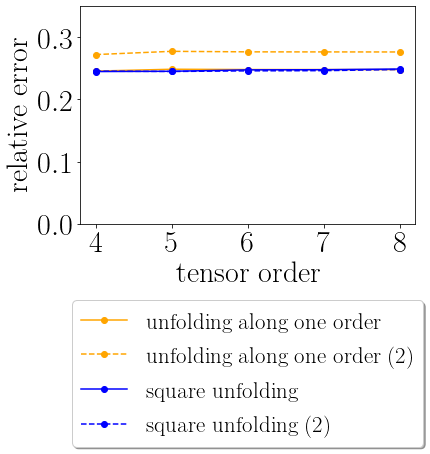

In [81]:
fontsize = 30
point_size = 50

colors = ['orange', 'blue', 'red', 'purple', 'black', 'green', 'cyan']

plt.plot(orders, errors_MCAR_rect, 'bo', linestyle='-', color=colors[0], label='unfolding along one order')
plt.plot(orders, errors_MCAR_rect_larger, 'bo', linestyle='--', color=colors[0], label='unfolding along one order (2)')
plt.plot(orders, errors_MCAR_sq, 'bo', linestyle='-', color=colors[1], label='square unfolding')
plt.plot(orders, errors_MCAR_sq_larger, 'bo', linestyle='--', color=colors[1], label='square unfolding (2)')

plt.xlabel('tensor order', fontsize=fontsize)
plt.ylabel('relative error', fontsize=fontsize)

xtick_pos = orders
ytick_pos = [0.1*i for i in np.arange(4)]
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

plt.ylim(0, 0.35)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-7)

Figure 1(b)

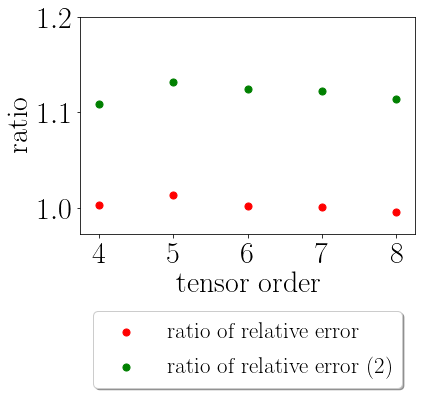

In [84]:
fontsize = 30
point_size = 50

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black', 'cyan']

plt.scatter(orders, np.array(errors_MCAR_rect) / np.array(errors_MCAR_sq), s=point_size, color=colors[2], label='ratio of relative error')
plt.scatter(orders, np.array(errors_MCAR_rect_larger) / np.array(errors_MCAR_sq_larger), s=point_size, color=colors[3], label='ratio of relative error (2)')

plt.xlabel('tensor order', fontsize=fontsize)
plt.ylabel('ratio', fontsize=fontsize)

ytick_pos = [1, 1.1, 1.2]
plt.xticks(fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-7)

Model B: MNAR

In [85]:
def get_propensity_errors_non_uniform_at_tensor_order(N, parameter_ratio=1.5):
    print("order: {}".format(N))
    r = [2 for _ in range(N)]
    
    # generate parameter tensor
    A_noise_para = 0.1
    np.random.seed(2)
    A_real_core = 2 * np.random.uniform(0,1,r)
    A_factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
    real_A = tucker_to_tensor((A_real_core, A_factor_matrices))
    A_fro_norm = np.linalg.norm(real_A)
    A_noise_coeff = A_noise_para * A_fro_norm / I ** (len(r)*1./2)
    A_noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))
    A = real_A + A_noise_coeff * A_noise_ten
    
    A_rect = tl.unfold(A, mode=0)
    _, A_Sigma, _ = randomized_svd(A_rect, n_components=10, n_iter=20, random_state=None)
    alpha_of_A_rect = np.max(np.abs(A_rect))
    theta_of_A_rect = np.sum(A_Sigma) / (np.sqrt(np.prod(A_rect.shape)))
    
    relative_error_rect, elapsed_rect = get_propensity_errors_from_A(
        A, tau=parameter_ratio*theta_of_A_rect, gamma=parameter_ratio*alpha_of_A_rect, max_rank=None, method='rectangular')
    
    A_sq = square_unfolding(A)
    _, A_Sigma, _ = randomized_svd(A_sq, n_components=10, n_iter=20, random_state=None)
    alpha_of_A_sq = np.max(np.abs(A_sq))
    theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape)))
    
    relative_error_sq, elapsed_sq = get_propensity_errors_from_A(
        A, tau=parameter_ratio*theta_of_A_rect, gamma=parameter_ratio*alpha_of_A_rect, max_rank=None, method='square')
    
    
    print("order: {} finished".format(N))
    return relative_error_rect, relative_error_sq, elapsed_rect, elapsed_sq   

an instance of the 1-bit completion experiment

In [86]:
get_propensity_errors_non_uniform_at_tensor_order(6, parameter_ratio=1)

order: 6
tau: 0.024478051061951063, gamma: 0.4732955648490587, max_rank: None
tau: 0.024478051061951063, gamma: 0.4732955648490587, max_rank: None
order: 6 finished


(0.009392374130923187,
 0.008383333680063745,
 0.08978533744812012,
 0.3233203887939453)

run the 1-bit completion experiments in parallel for MNAR tensor with $\tau = \theta$, $\gamma = \alpha$

In [89]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_propensity_errors_non_uniform_at_tensor_order, args=[N, 1]) for N in orders]
p.close()
p.join()

order: 6
order: 5
order: 7
order: 8
order: 4
tau: 0.07677415212450625, gamma: 0.4570851524620143, max_rank: None
tau: 0.07677415212450625, gamma: 0.4570851524620143, max_rank: None
order: 4 finished
tau: 0.042002011553797916, gamma: 0.43860386093507936, max_rank: None
tau: 0.042002011553797916, gamma: 0.43860386093507936, max_rank: None
order: 5 finished
tau: 0.024478051061951063, gamma: 0.4732955648490587, max_rank: None
tau: 0.024478051061951063, gamma: 0.4732955648490587, max_rank: None
order: 6 finished
tau: 0.012803822687254636, gamma: 0.2993852203892347, max_rank: None
tau: 0.012803822687254636, gamma: 0.2993852203892347, max_rank: None
order: 7 finished
tau: 0.006493589646487807, gamma: 0.3491348879506197, max_rank: None
tau: 0.006493589646487807, gamma: 0.3491348879506197, max_rank: None
order: 8 finished


In [90]:
errors_rect = []
errors_sq = []
elapsed_times_rect = []
elapsed_times_sq = []

for result in results:
    errors_rect.append(result.get()[0])
    errors_sq.append(result.get()[1])
    elapsed_times_rect.append(result.get()[2])
    elapsed_times_sq.append(result.get()[3])

errors_rect_dict = dict(zip(orders, errors_rect))
errors_sq_dict = dict(zip(orders, errors_sq))

run the 1-bit completion experiments in parallel for MNAR tensor with $\tau = 2\theta$, $\gamma = 2\alpha$

In [91]:
p = mp.Pool(mp.cpu_count())
results = [p.apply_async(get_propensity_errors_non_uniform_at_tensor_order, args=[N, 2]) for N in orders]
p.close()
p.join()

order: 7
order: 4
order: 5
order: 6
order: 8
tau: 0.1535483042490125, gamma: 0.9141703049240286, max_rank: None
tau: 0.08400402310759583, gamma: 0.8772077218701587, max_rank: None
tau: 0.1535483042490125, gamma: 0.9141703049240286, max_rank: None
order: 4 finished
tau: 0.08400402310759583, gamma: 0.8772077218701587, max_rank: None
order: 5 finished
tau: 0.048956102123902126, gamma: 0.9465911296981174, max_rank: None
tau: 0.048956102123902126, gamma: 0.9465911296981174, max_rank: None
order: 6 finished
tau: 0.025607645374509273, gamma: 0.5987704407784694, max_rank: None
tau: 0.025607645374509273, gamma: 0.5987704407784694, max_rank: None
order: 7 finished
tau: 0.012987179292975614, gamma: 0.6982697759012394, max_rank: None
tau: 0.012987179292975614, gamma: 0.6982697759012394, max_rank: None
order: 8 finished


In [92]:
errors_rect_larger = []
errors_sq_larger = []
elapsed_times_rect_larger = []
elapsed_times_sq_larger = []

for result in results:
    errors_rect_larger.append(result.get()[0])
    errors_sq_larger.append(result.get()[1])
    elapsed_times_rect_larger.append(result.get()[2])
    elapsed_times_sq_larger.append(result.get()[3])

errors_rect_larger_dict = dict(zip(orders, errors_rect_larger))
errors_sq_larger_dict = dict(zip(orders, errors_sq_larger))

Figure 1(c)

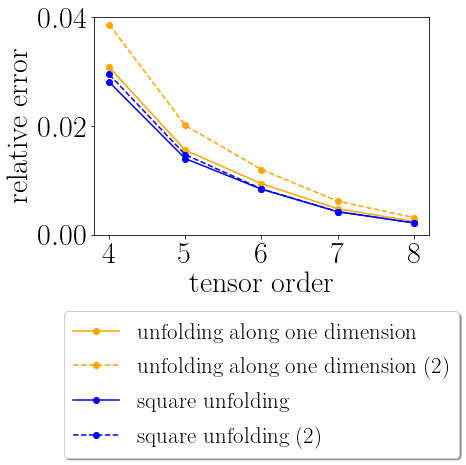

In [97]:
fontsize = 30
point_size = 50

colors = ['orange', 'blue', 'red', 'purple', 'black', 'green', 'cyan']

plt.plot(orders, errors_rect, 'bo', linestyle='-', color=colors[0], label='unfolding along one dimension')
plt.plot(orders, errors_rect_larger, 'bo', linestyle='--', color=colors[0], label='unfolding along one dimension (2)')
plt.plot(orders, errors_sq, 'bo', linestyle='-', color=colors[1], label='square unfolding')
plt.plot(orders, errors_sq_larger, 'bo', linestyle='--', color=colors[1], label='square unfolding (2)')

plt.xlabel('tensor order', fontsize=fontsize)
plt.ylabel('relative error', fontsize=fontsize)

xtick_pos = orders
ytick_pos = [0.02*i for i in [0, 1, 2]]
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

plt.ylim(0, 0.04)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-7)

Figure 1(d)

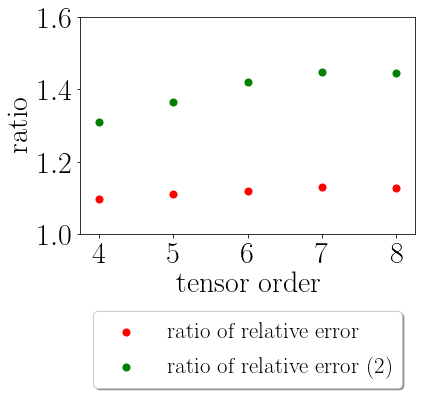

In [94]:
fontsize = 30
point_size = 50

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black', 'cyan']

plt.scatter(orders, np.array(errors_rect) / np.array(errors_sq), s=point_size, color=colors[2], label='ratio of relative error')
plt.scatter(orders, np.array(errors_rect_larger) / np.array(errors_sq_larger), s=point_size, color=colors[3], label='ratio of relative error (2)')

plt.xlabel('tensor order', fontsize=fontsize)
plt.ylabel('ratio', fontsize=fontsize)

xtick_pos = orders
ytick_pos = [1, 1.2, 1.4, 1.6]
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-7)